# **Textanalysis travel literature and print media**

### 1. Preprocess Travel and Media Texts (Stanza-based)

In [1]:
from google.colab import files

# Upload CSVs
uploaded = files.upload()

Saving bild_cleaned.csv to bild_cleaned.csv
Saving krone_cleaned.csv to krone_cleaned.csv
Saving standard_cleaned.csv to standard_cleaned.csv
Saving travel_cleaned.csv to travel_cleaned.csv
Saving zeit_cleaned.csv to zeit_cleaned.csv


In [2]:
!pip install -q stanza sentence-transformers transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 32.7 MB/s eta 0:00:00


In [3]:
#import required libaries
import pandas as pd
import numpy as np
import stanza
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

In [4]:
# Download and initialize Stanza German model
stanza.download('de')
nlp = stanza.Pipeline('de', processors='tokenize,mwt,pos,lemma', use_gpu=False)


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: de (German) ...


INFO:stanza:Downloaded file to /root/stanza_resources/de/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: de (German):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


In [5]:
# Load CSV files
travel_df = pd.read_csv('travel_cleaned.csv', delimiter=';', quoting=1)
travel_df.rename(columns={'traveltext': 'text'}, inplace=True)
travel_df['source'] = 'travel'

# Load and rename media DataFrames
bild_df = pd.read_csv('bild_cleaned.csv', delimiter=';')
bild_df.rename(columns={'bild_text': 'text'}, inplace=True)
bild_df['source'] = 'bild'

krone_df = pd.read_csv('krone_cleaned.csv', delimiter=';')
krone_df.rename(columns={'krone_text': 'text'}, inplace=True)
krone_df['source'] = 'krone'

zeit_df = pd.read_csv('zeit_cleaned.csv', delimiter=';')
zeit_df.rename(columns={'zeit_text': 'text'}, inplace=True)
zeit_df['source'] = 'zeit'

standard_df = pd.read_csv('standard_cleaned.csv', delimiter=';')
standard_df.rename(columns={'derstandard_text': 'text'}, inplace=True)
standard_df['source'] = 'standard'

# Combine all media
media_df = pd.concat([bild_df, krone_df, zeit_df, standard_df], ignore_index=True)


In [6]:
def preprocess(text):
    doc = nlp(str(text))
    return [
        word.lemma.lower()
        for sentence in doc.sentences
        for word in sentence.words
        if word.upos in {'NOUN', 'VERB', 'ADJ'}
    ]

In [7]:
# Preprocess texts using Stanza
tqdm.pandas()

travel_df['tokens'] = travel_df['text'].progress_apply(preprocess)
media_df['tokens'] = media_df['text'].progress_apply(preprocess)


100%|██████████| 30/30 [01:01<00:00,  2.05s/it]


### 2. Detect Stereotypes

In [8]:
# define stereotype keywords for detecting
stereotype_keywords = { "araber", "moslem", "moslems", "islam", "glaube", "haram", "pilger", "ungläubig",
    "frau", "frauen", "mädchen", "verhüllt", "geschlecht", "sexuell", "arabisch", "mann", "männer",
    "neger", "ausländer", "ethnisch", "volk", "stamm", "unterdrückt", "unzivilisiert"
    "nackt", "hässlich", "schön", "dick", "triefend", "verwelkt", "aggressiv",
    "faul", "laut", "wild", "primitiv", "gewalttätig", "unterwürfig", "barbarisch", "terror", "terrorist"
}

def detect_stereotypes(tokens):
    return list(set(tokens) & stereotype_keywords)

travel_df['stereotypes'] = travel_df['tokens'].apply(detect_stereotypes)
media_df['stereotypes'] = media_df['tokens'].apply(detect_stereotypes)

stereo_travel_df = travel_df[travel_df['stereotypes'].apply(len) > 0].copy()
stereo_media_df = media_df[media_df['stereotypes'].apply(len) > 0].copy()


### 3. Sentence Embeddings + Categories

In [9]:
combined_df = pd.concat([travel_df, media_df], ignore_index=True)

In [10]:
def assign_category(tokens):
    categories = []
    if any(k in tokens for k in ['frau', 'frauen', 'geschlecht', 'mädchen', 'mann', 'männer', 'sexuell']):
        categories.append('gender')
    if any(k in tokens for k in ['moslem', 'islam', 'haram', 'glaube', 'terror', 'gewalt', 'ungläubig']):
        categories.append('religious')
    if any(k in tokens for k in ['wild', 'laut', 'faul', 'gewalttätig',"unterwürfig", "barbarisch", "primitiv"]):
        categories.append('behavioral')
    if any(k in tokens for k in ['ausländer', 'ethnisch', 'volk', 'arabisch', 'neger']):
        categories.append('ethnic')
    if any(k in tokens for k in ['nackt', 'hässlich', 'schön', 'verhüllt', 'schleier']):
        categories.append('appearance')
    return categories


In [11]:
# Assign categories
combined_df['categories'] = combined_df['tokens'].apply(assign_category)
combined_df = combined_df[combined_df['categories'].apply(len) > 0].copy()
combined_df['primary_category'] = combined_df['categories'].apply(lambda x: x[0])



In [12]:
# Set N = number of paragraphs per source to include
N = 15

# Balance media sources
balanced_stereo_media_df = pd.concat([
    stereo_media_df[stereo_media_df['source'] == src].sample(
        n=min(N, len(stereo_media_df[stereo_media_df['source'] == src])),
        random_state=42
    )
    for src in stereo_media_df['source'].unique()
], ignore_index=True)

# Balance travel source
balanced_stereo_travel_df = stereo_travel_df.sample(
    n=min(N, len(stereo_travel_df)),
    random_state=42
)

# Combine balanced DataFrame
combined_df = pd.concat([
    balanced_stereo_travel_df[['text', 'tokens', 'source']],
    balanced_stereo_media_df[['text', 'tokens', 'source']]
], ignore_index=True)


print("Paragraphs per source (after balancing):")
print(combined_df['source'].value_counts())


Paragraphs per source (after balancing):
source
travel      15
krone       10
bild         4
zeit         4
standard     2
Name: count, dtype: int64


In [13]:
# Load multilingual embedding model
model = SentenceTransformer('distiluse-base-multilingual-cased-v1')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

2_Dense/pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

In [17]:
# Combine stereotype-bearing paragraphs
combined_df = pd.concat([
    stereo_travel_df[['text', 'tokens', 'source']],
    stereo_media_df[['text', 'tokens', 'source']]
], ignore_index=True)

# Define manual stereotype categories
stereotype_categories = stereotype_categories = {
    'religious': {"moslem", "moslems", "islam", "glaube", "haram", "pilger", "ungläubig" , "terror", "muslim"},
    'gender': {"frau", "frauen", "mädchen", "verhüllt", "geschlecht", "sexuell", "mann", "männer"},
    'ethnic_cultural': {"araber", "neger", "ausländer", "ethnisch", "volk", "stamm", "arabisch"},
    'appearance': {"nackt", "hässlich", "schön", "dick", "triefend", "verwelkt", "verhüllt"},
    'behavioral': {"faul", "laut", "wild", "primitiv", "gewalttätig", "aggressiv", "unterwürfig", "barbarisch", "terroristisch", "wütend",
                   }
}

# Assign categories
def assign_category(tokens):
    return [cat for cat, kws in stereotype_categories.items() if set(tokens) & kws]

combined_df['categories'] = combined_df['tokens'].apply(assign_category)

# Filter: keep only paragraphs with at least one category
combined_df = combined_df[combined_df['categories'].apply(len) > 0].copy()

# Create primary category column
combined_df['primary_category'] = combined_df['categories'].apply(lambda x: x[0])

#  RUN sentence embeddings after filtering combined_df
embeddings = model.encode(combined_df['text'].tolist(), show_progress_bar=True)



Batches:   0%|          | 0/2 [00:00<?, ?it/s]

### 4. t-SNE Visualization for Clustering (Color = Category, Shape = Source)


📊 Stereotype Category Distribution (%):
          Category  Percentage
0        religious        36.5
1           gender        34.6
2  ethnic_cultural        25.0
3       appearance         3.8


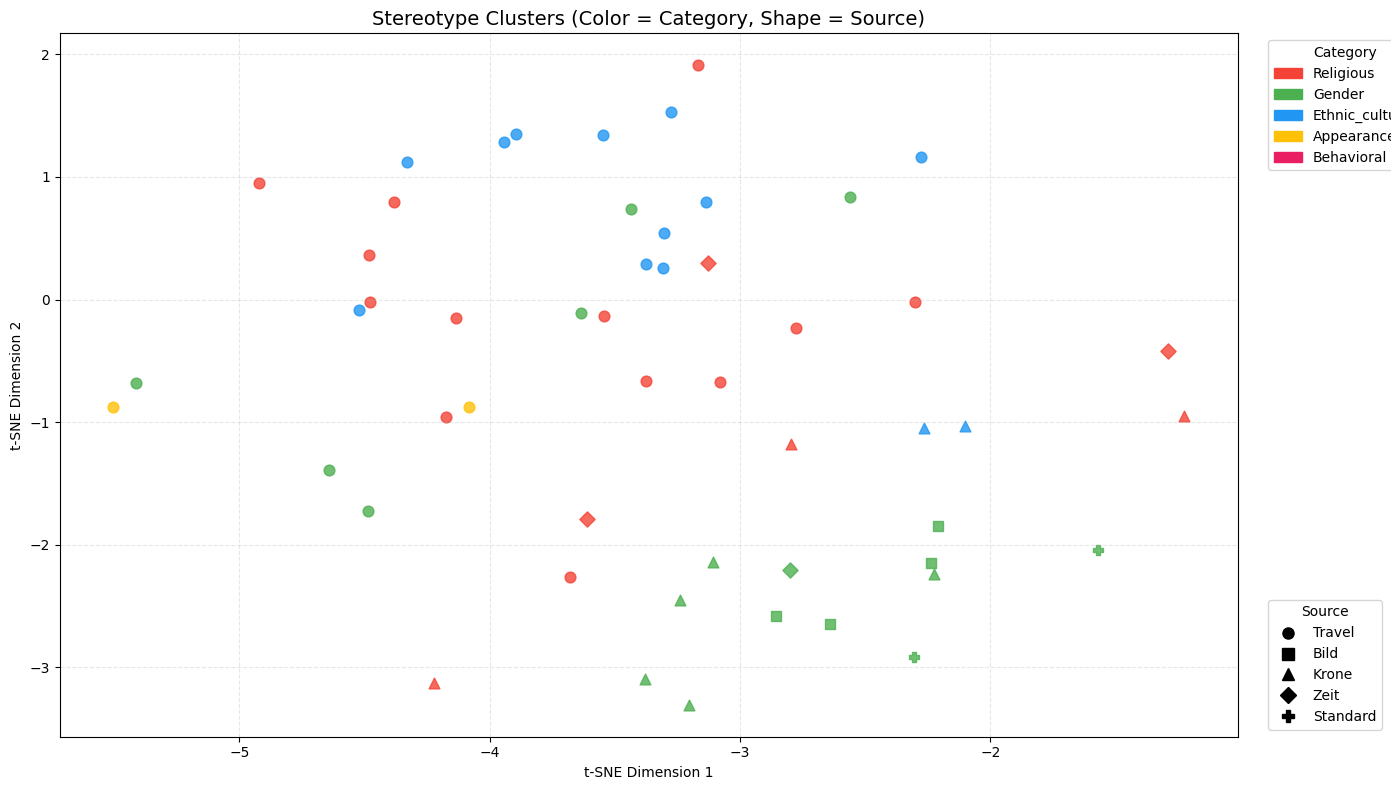

In [18]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(embeddings)

combined_df['x'] = X_tsne[:, 0]
combined_df['y'] = X_tsne[:, 1]

# Define colors and shapes
category_colors = {
    'religious': '#F44336', #amber
    'gender': '#4CAF50', #green
    'ethnic_cultural': '#2196F3', #blue
    'appearance': '#FFC107', #yellow
    'behavioral': '#E91E63' #pink
}

source_markers = {
    'travel': 'o',
    'bild': 's',
    'krone': '^',
    'zeit': 'D',
    'standard': 'P'
}

# Plot: Color = Category, Shape = Source
plt.figure(figsize=(14, 8))

for cat in combined_df['primary_category'].unique():
    for src in combined_df['source'].unique():
        sub = combined_df[(combined_df['primary_category'] == cat) & (combined_df['source'] == src)]
        if not sub.empty:
            plt.scatter(sub['x'], sub['y'],
                        color=category_colors[cat],
                        marker=source_markers[src],
                        s=60, alpha=0.8)

# Separate legends
cat_legend = [mpatches.Patch(color=v, label=k.capitalize()) for k, v in category_colors.items()]
src_legend = [mlines.Line2D([], [], color='black', marker=v, linestyle='None', label=k.capitalize(), markersize=8) for k, v in source_markers.items()]

legend1 = plt.legend(handles=cat_legend, title="Category", loc='upper left', bbox_to_anchor=(1.02, 1))
legend2 = plt.legend(handles=src_legend, title="Source", loc='lower left', bbox_to_anchor=(1.02, 0))
plt.gca().add_artist(legend1)

category_percentages = (
    combined_df['primary_category']
    .value_counts(normalize=True) * 100
).round(1).rename_axis('Category').reset_index(name='Percentage')

print("\n📊 Stereotype Category Distribution (%):")
print(category_percentages)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("Stereotype Clusters (Color = Category, Shape = Source)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("stereotype_clusters_final.png", dpi=300)
plt.show()

### 5. Sentiment Analysis using BERT

In [19]:
model_name = "oliverguhr/german-sentiment-bert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/161 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Device set to use cpu


In [20]:
def extract_sentiment(text):
    # Truncate to 512 tokens at most (approx. 1000 characters to be safe)
    text = str(text)[:1000]

    try:
        result = sentiment_pipeline(text)[0]
        label = result['label'].upper()
        score = result['score']
        return pd.Series([label, score])
    except Exception as e:
        print("Error:", e)
        return pd.Series(["ERROR", 0])

In [21]:
# Apply to filtered paragraphs
combined_df[['sentiment_label', 'sentiment_score']] = combined_df['text'].apply(extract_sentiment)


In [22]:
def adjust_neutral(row):
    if row['sentiment_label'] == 'NEUTRAL' and row['sentiment_score'] < 0.6:
        return 'UNCERTAIN'
    return row['sentiment_label']

combined_df['sentiment_final'] = combined_df.apply(adjust_neutral, axis=1)


In [23]:
print(combined_df['sentiment_final'].value_counts(dropna=False))


sentiment_final
NEUTRAL      33
NEGATIVE     17
POSITIVE      1
UNCERTAIN     1
Name: count, dtype: int64


In [24]:
combined_df[combined_df['sentiment_final'] == 'UNCERTAIN'][['text', 'source', 'sentiment_score']].to_csv("uncertain_sentiment_samples.csv", index=False)


📊 Sentiment Distribution (%):
   Sentiment  Percentage
0    NEUTRAL        63.5
1   NEGATIVE        32.7
2   POSITIVE         1.9
3  UNCERTAIN         1.9


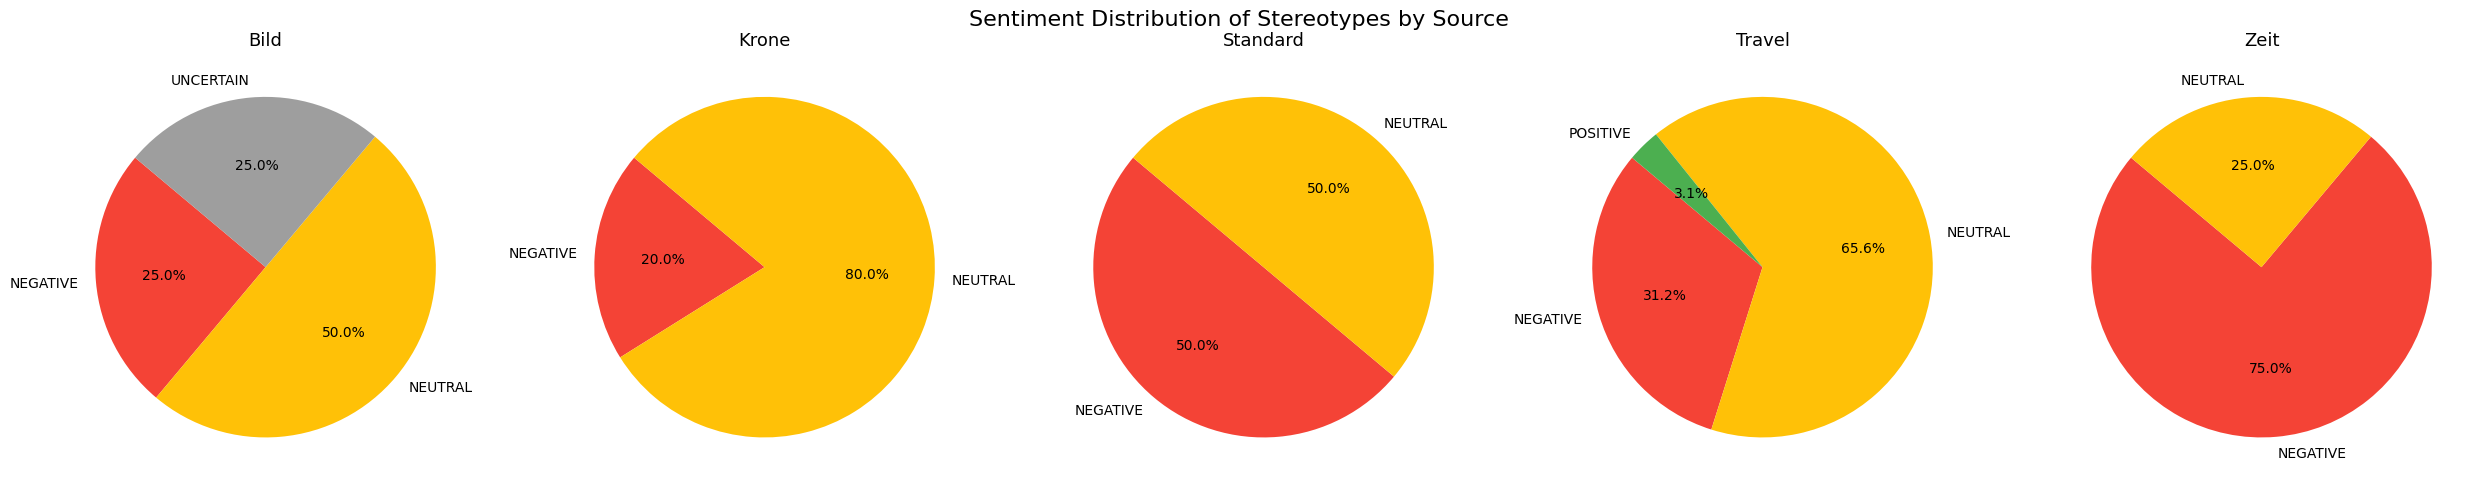

In [25]:
# Choose the correct sentiment column
sentiment_column = 'sentiment_final'  # or 'sentiment_label'
total_sentences = len(combined_df)

sentiment_percentages = (
    combined_df[sentiment_column]
    .value_counts(normalize=True) * 100
).round(1).rename_axis('Sentiment').reset_index(name='Percentage')

# Set pie chart colors
sentiment_colors = {
    'NEGATIVE': '#F44336',
    'NEUTRAL': '#FFC107',
    'POSITIVE': '#4CAF50',
    'UNCERTAIN': '#9E9E9E',
    'ERROR': '#BDBDBD'
}

# Group by source and sentiment
grouped = combined_df.groupby(['source', sentiment_column]).size().unstack(fill_value=0)
combined_df[sentiment_column] = combined_df[sentiment_column].str.upper()

# Create subplots
fig, axes = plt.subplots(1, len(grouped), figsize=(5 * len(grouped), 5))

if len(grouped) == 1:
    axes = [axes]  # Ensure iterable for single plot

# Plot one pie chart per source
for ax, (source, row) in zip(axes, grouped.iterrows()):
    sentiments = row.to_dict()
    labels = [label for label in sentiments if sentiments[label] > 0]
    sizes = [sentiments[label] for label in labels]
    colors = [sentiment_colors.get(label, '#AAAAAA') for label in labels]

    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
    ax.set_title(f"{source.capitalize()}", fontsize=13)



plt.suptitle("Sentiment Distribution of Stereotypes by Source", fontsize=16)
plt.tight_layout()
print("📊 Sentiment Distribution (%):")
print(sentiment_percentages)
plt.show()

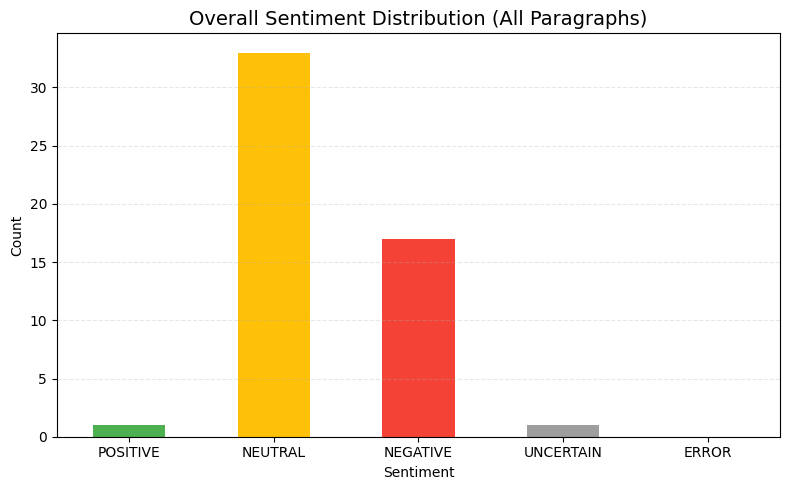

In [26]:
# --- Chart: Bar Chart of All Sentiment Counts ---
sentiment_counts = combined_df[sentiment_column].value_counts().reindex(['POSITIVE', 'NEUTRAL', 'NEGATIVE', 'UNCERTAIN', 'ERROR'], fill_value=0)

plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind='bar', color=[sentiment_colors.get(x, '#CCCCCC') for x in sentiment_counts.index])
plt.title("Overall Sentiment Distribution (All Paragraphs)", fontsize=14)
plt.ylabel("Count")
plt.xlabel("Sentiment")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("overall_sentiment_distribution_bar.png", dpi=300)
plt.show()

In [27]:
# --- Table: Display All Paragraphs by Sentiment ---
# Optional: View and export all paragraphs by tone
sentiment_table = combined_df[['source', 'text', sentiment_column]].sort_values(by=sentiment_column)
sentiment_table.to_csv("paragraphs_by_sentiment.csv", index=False)

print("\nParagraph Sentiment Overview:")
display(sentiment_table.head(10))


Paragraph Sentiment Overview:


,source,text,sentiment_final
51,standard,Spielfeld – Kalt ist es geworden in Spielfeld....,NEGATIVE
26,travel,Die sie begleitenden Araber waren ungefähr das...,NEGATIVE
31,travel,"Alles, was die Kaaba und ihren Pilgerdienst be...",NEGATIVE
32,bild,In der Nacht zu Donnerstag gerieten syrische u...,NEGATIVE
22,travel,Obgleich die Araber die Erfinder des Compasses...,NEGATIVE
21,travel,Hier kamen mir meine mitgenommenen Wasserflasc...,NEGATIVE
19,travel,"Aber der Araber, sei er nun Fellah, Städter od...",NEGATIVE
18,travel,Hier fand ich nun zu meinem nicht geringen Ers...,NEGATIVE
38,krone,"Wie berichtet, wurden mindestens 100 Frauen vo...",NEGATIVE
14,travel,Heute musste ich leider an diesen antiken Schä...,NEGATIVE


### 6. Travel vs. Media: Stereotype Semantic Similarity

📊 Average Semantic Similarity with Travel Paragraphs (%):
source
bild        16.1
krone       19.5
standard    12.9
zeit        23.5
Name: Cosine Similarity (%), dtype: float32


/tmp/ipython-input-28-3887812083.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cosine_similarity_pct.values, y=cosine_similarity_pct.index, palette='Blues_d')


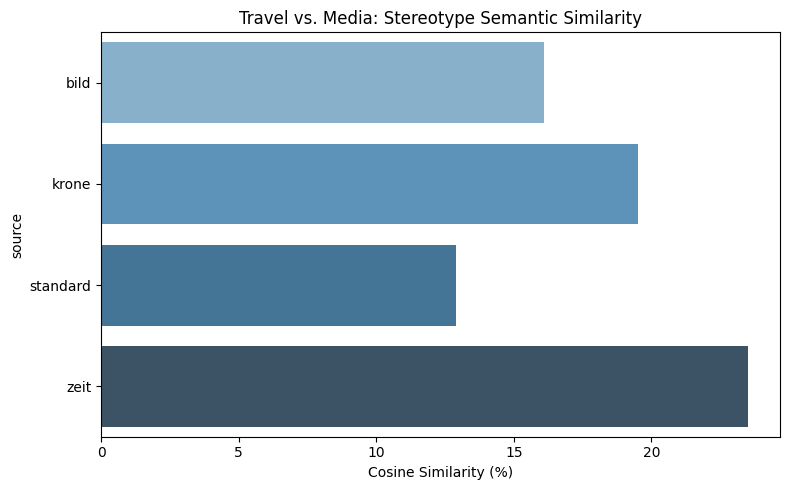

In [28]:
# Compute similarity matrix between travel and media embeddings
travel_embed = embeddings[combined_df['source'] == 'travel']
media_embed = embeddings[combined_df['source'] != 'travel']
sim_matrix = cosine_similarity(travel_embed, media_embed)

# Build similarity DataFrame
media_labels = combined_df[combined_df['source'] != 'travel'].reset_index(drop=True)['source']
df_sim = pd.DataFrame(sim_matrix, columns=media_labels)

# Calculate average cosine similarity by media source
cosine_similarity_pct = (
    df_sim.mean().groupby(level=0).mean() * 100
).round(1).rename("Cosine Similarity (%)")

# Print results
print("📊 Average Semantic Similarity with Travel Paragraphs (%):")
print(cosine_similarity_pct)

# Plot results
plt.figure(figsize=(8, 5))
sns.barplot(x=cosine_similarity_pct.values, y=cosine_similarity_pct.index, palette='Blues_d')
plt.xlabel("Cosine Similarity (%)")
plt.title("Travel vs. Media: Stereotype Semantic Similarity")
plt.tight_layout()
plt.savefig("semantic_similarity_embeddings.png", dpi=300)
plt.show()


In [29]:
# Step 1: Recreate matching between travel and media embeddings
travel_indices = combined_df[combined_df['source'] == 'travel'].index
media_indices = combined_df[combined_df['source'] != 'travel'].index

similar_pairs = []

for i, travel_idx in enumerate(travel_indices):
    similarities = sim_matrix[i]
    top_idx = np.argmax(similarities)
    media_idx = media_indices[top_idx]

    similar_pairs.append({
        'travel_text': combined_df.loc[travel_idx, 'text'],
        'media_text': combined_df.loc[media_idx, 'text'],
        'media_source': combined_df.loc[media_idx, 'source'],
        'similarity': similarities[top_idx]
    })

# Step 2: Create table
similarity_df = pd.DataFrame(similar_pairs)

# Step 3: Sort by similarity and show top N
top_n = 5
top_similar = similarity_df.sort_values(by='similarity', ascending=False).head(top_n)

# Optional: Save for further review
top_similar.to_csv("top_semantically_similar_pairs.csv", index=False)

# Step 4: Show table
import pandas as pd
pd.set_option('display.max_colwidth', None)  # show full text
display(top_similar[['media_source', 'similarity', 'travel_text', 'media_text']])


media_source  similarity  \
9          zeit    0.543853   
19         zeit    0.530821   
2          zeit    0.520727   
28        krone    0.457367   
18         zeit    0.454367   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       travel_text  \
9   Meine nächsten Nachbarn waren Aegypter und diese sind von allen Moslems, welche ich kennen lernte, noch die umgänglichsten und gemüthlichsten, ja ich möchte fast sagen , die am wenigsten fanatischen , wenn man überhaupt von einem Muselmann sagen kann, dass er nur w e n i g fanatisch sei. Die arabischen Aegypter stehen seit Jahrhunderten so tief unter dem Drucke der sie beherrschenden Türken, von denen sie aufs tyrannischste behandelt und bei jeder Gelegenheit gedemüthigt werden, dass sie viel von der Natur der unterdrückten Volksstämme angenommen haben   
19                                                                                            Aber der Araber, sei er nun Fellah, Städter oder Beduine, ist einmal, was seinen persönlichen Comfort betrifft, durchaus nicht verweichlicht und ich kann wirklich nicht begreifen, wie die byzantinischen Schriftsteller, wie Zonaras, Cantacuzenus, Georgas immer die Aegypter die sich bekanntlich in einem Jahrtausend so gut wie nicht verändert haben, und die wir folglich noch heute so sehen, wie sie zur Zeit Kaiser Zeno's waren, als so luxuriös und verwöhnt schildern.   
2                                                                                                                                                                                                                                                                                                              Diese ersten Bewohner Arabiens, welche ich hier zu sehen bekam, waren zerlumpte, halbnackte Menschen, von höchst kläglichem Aussehen, und entsprachen folglich durchaus nicht dem Begriffe, welchen sich die alten Periegeten von Arabern gemacht zu haben scheinen   
28                                                                                                                                                                                                                                                               Die Stelle eines kühleren Gemachs vertritt hier die Hausflur, wo der Hausherr inmitten des männlichen Personals des Hauses seinen Sitz auf schlägt, während das weibliche in die heissen Zimmer verbannt bleibt, in welchen die Frauen hier, wie überall in Ländern des Islam , eine Art von Gefangenleben führen   
18                               Hier fand ich nun zu meinem nicht geringen Erstaunen, dass ich der einzige war, der eine solche Vorsichtsmassregel gebrauchte. Nicht, als ob die Araber nicht so viel, wie wir, ja noch mehr, wie wir Europäer, vom Durst geplagt würden, da sie viel mehr, als wir, an häufiges Wassertrinken gewohnt sind; aber so gross ist ihre Sorglosigkeit, dass sie lieber leiden wollen, als sich die Mühe machen, ein wenig an die Zukunft zu denken. Nur· für sehr grosse Wüstenreisen, durch völlig oasenlose Strecken, nehmen diese Leute Wasser mit   

                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [30]:
# --- Enable Download in Colab ---
try:
    from google.colab import files
    print("\n📥 Download links:")
    files.download("paragraphs_by_sentiment.csv")
    files.download("top_semantically_similar_pairs.csv")
except Exception as e:
    print("(Download not available outside of Colab):", e)


📥 Download links:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>